In [1]:
!source /etc/profile

import os
import sys
import random
import time
from collections import deque
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Activation, Flatten, MaxPooling2D, Conv2D
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras import utils
import matplotlib.pyplot as plt
import json
import joblib

# Check GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# tf.config.list_physical_devices()

Num GPUs Available:  1


2022-02-27 03:11:41.488704: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-27 03:11:41.609721: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-27 03:11:41.610423: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
SEQ_LEN = 48 #hours
FUTURE_PERIOD_PREDICT = 1 #hours

csv_file = "data/formatted/BTCUSDT-1h-data.csv"
model_path = "models/TANH3-e20-b16-s48-fpp1-1645639574.model"
scaler_path = "scalers/" + model_path.split("/")[1].split(".")[0] + "/"

In [3]:
## Import data
# DATA MUST BE FORMATTED USING CSV_FORMATTER.IPYNB



data = pd.read_csv(csv_file, skiprows=[0], names=["timestamp", "open", "high", "low", "close", "volume", "rsi", "ema"])

data.set_index("timestamp", inplace=True)

data.head()

,open,high,low,close,volume,rsi,ema
timestamp,,,,,,,
1503064800,4304.15,4371.52,4296.04,4356.31,51.563675,52.623958,4327.151560
1503068400,4356.31,4357.37,4302.72,4340.31,24.093449,51.678528,4327.804777
1503072000,4320.52,4340.31,4287.79,4331.71,15.118957,51.167386,4327.995329
1503075600,4302.97,4318.16,4221.05,4293.09,46.533767,48.919621,4326.319858
1503079200,4293.09,4293.09,4193.70,4259.40,74.368943,47.054235,4323.157459


In [4]:
## Formatting data

# def classify(current, future):
#     return float((future - current) / current)


# data["future"] = data["close"].shift(-FUTURE_PERIOD_PREDICT)

# Cut off NaNs
# data = data[:-FUTURE_PERIOD_PREDICT]
data.dropna(inplace=True)

# data["target"] = list(map(classify, data["close"], data["future"]))
# data[["close", "future", "target"]].tail()
# data = data.drop("future", 1)


## Load scalers
price_scaler = joblib.load(os.path.join(scaler_path, "price_scaler"))
volume_scaler = joblib.load(os.path.join(scaler_path, "volume_scaler"))
rsi_scaler = joblib.load(os.path.join(scaler_path, "rsi_scaler"))


# Split dataset
# last_5_pct = int(len(data) * .95)

# train_data = data[:last_5_pct]
# validation_data = data[last_5_pct:]

# print(f"{len(train_data)} :: {len(validation_data)}")

data.head()

,open,high,low,close,volume,rsi,ema
timestamp,,,,,,,
1503064800,4304.15,4371.52,4296.04,4356.31,51.563675,52.623958,4327.151560
1503068400,4356.31,4357.37,4302.72,4340.31,24.093449,51.678528,4327.804777
1503072000,4320.52,4340.31,4287.79,4331.71,15.118957,51.167386,4327.995329
1503075600,4302.97,4318.16,4221.05,4293.09,46.533767,48.919621,4326.319858
1503079200,4293.09,4293.09,4193.70,4259.40,74.368943,47.054235,4323.157459


In [5]:
## Preprocess Data

def preprocess_df(df_p):

    df = pd.DataFrame()
    for col in df_p.columns:
        df[col] = df_p[col]

    for col in df.columns:
        scaler = None
        if col in ["open", "high", "low", "close", "ema", "target"]:
            scaler = price_scaler
        elif col == "volume":
            scaler = volume_scaler
        elif col == "rsi":
            scaler = rsi_scaler
        else:
            raise Exception("Column not recognized and scaler cannot be determined")

        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.dropna(inplace=True)
        df[col] = scaler.transform(np.array(df[col]).reshape(-1, 1))


    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)

    sequential_data = []
    prev_periods = deque(maxlen=SEQ_LEN)

    for i in df.values:
        prev_periods.append([n for n in i])
        if len(prev_periods) == SEQ_LEN:
            sequential_data.append([np.array(prev_periods), i])

    # random.shuffle(sequential_data)

    # # Balance buys and sells
    # buys = []
    # sells = []

    # for seq, target in sequential_data:

    #     if target < 0.0:
    #         sells.append([seq, target])
    #     elif target > 0.0:
    #         buys.append([seq, target])

    # lower = min(len(buys), len(sells))

    # buys = buys[:lower]
    # sells = sells[:lower]

    # sequential_data = buys + sells

    # random.shuffle(sequential_data)

    X = [d[0] for d in sequential_data]
    # Y = [d[1] for d in sequential_data]

    # return np.array(X), np.array(Y)
    return np.array(X)
    
    
seq_data = preprocess_df(data)

In [6]:
## Load model

model = load_model(model_path)
model.summary()


2022-02-27 03:11:43.540582: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-27 03:11:43.541764: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-27 03:11:43.542474: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-27 03:11:43.543050: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48, 1024)          4227072   
                                                                 
 dropout (Dropout)           (None, 48, 1024)          0         
                                                                 
 batch_normalization (BatchN  (None, 48, 1024)         4096      
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 32)                135296    
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

In [7]:
bal = 10000
usd_bal = 10000
coin_bal = 0

price = 234890

list(data["close"])[0+24]

# print(f"BAL {bal}\tUSD {usd_bal}\tCOIN {coin_bal}")

4000.58

In [8]:
with tf.device("/device:GPU:0"):
    pred = model.predict(seq_data)

    # print(json.dumps([float(list(d)[0]) for d in list(model.predict(seq_data))], indent=4))
    

pred

2022-02-27 03:11:52.517384: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


array([[-0.9365634 ],
       [-0.936717  ],
       [-0.9371432 ],
       ...,
       [-0.00356056],
       [ 0.0187093 ],
       [ 0.02447419]], dtype=float32)

In [9]:
unscaled_pred = price_scaler.inverse_transform(pred)
len(unscaled_pred)

38581

In [10]:
# get_price(38600)
# list(data["close"])[38648]
len(data["close"]) - 47
# len(seq_data)

38581

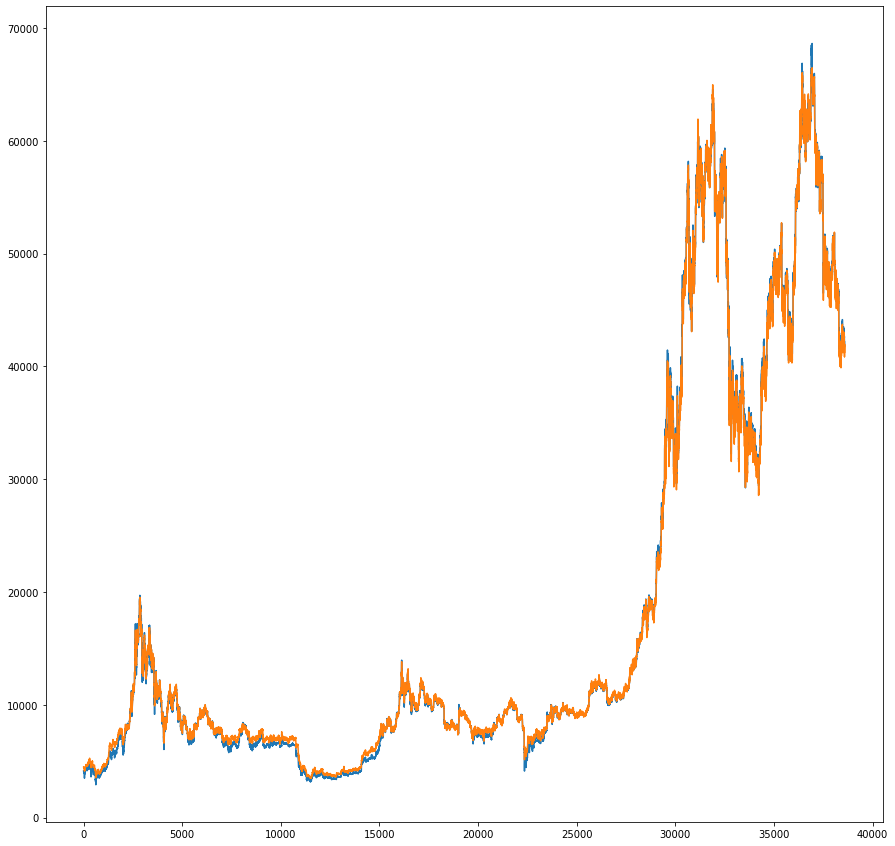

In [11]:
plt.rcParams["figure.figsize"] = (15,15)

x = list(range(len(unscaled_pred)))
lim = 0


plt.plot(x, data["close"][47+lim:], label="real")
plt.plot(x, unscaled_pred.tolist()[lim:], label="pred")
plt.show()

In [135]:
# import random
# # state = "first"

# if state == "first":
#     print(state)
#     i = random.randint(30000, len(unscaled_pred))
#     plt.plot(list(range(len(seq_data[0]))), list(data["close"])[i+48:i+48+48])
#     # plt.scatter([len(seq_data[0])-1], list(data["close"])[i+48+47])
#     state = "second"
# elif state == "second":
#     print(state)
#     plt.plot(list(range(len(seq_data[0]))), list(data["close"])[i+48:i+48+48])
#     plt.scatter([len(seq_data[0])+1], unscaled_pred[i])
#     state = "third"
# elif state == "third":
#     print(state)
#     plt.plot(list(range(len(seq_data[0])+1)), list(data["close"])[i+48:i+48+49])
#     plt.scatter([len(seq_data[0])+1], unscaled_pred[i])
#     state = "first"

In [20]:
## Trading bot (test only)

start_seq = 0

islong = False

json_msgs = []

bal = 10000.0
usd_bal = bal
coin_bal = 0.0

model_trade_x = list(range(start_seq, len(seq_data) + 1))
model_trade_y = []
position_y = []

def do_buy(price):
    global usd_bal
    global coin_bal
    global islong

    if usd_bal == 0:
        return

    islong = True

    usd_bal -= usd_bal * calc_fee()
    coin_bal += (usd_bal / price)
    usd_bal = 0

    calc_bal(price)

def do_sell(price):
    global usd_bal
    global coin_bal
    global islong

    if coin_bal == 0:
        return

    islong = False

    usd_bal += (coin_bal * price)
    usd_bal -= usd_bal * calc_fee()
    coin_bal = 0

    calc_bal(price)

def calc_bal(price):
    global bal
    bal = usd_bal + (coin_bal * price)

def calc_fee():
    # return 0
    if bal > 1000000:
        return .0018
    elif bal > 100000:
        return .0020
    elif bal > 50000:
        return .0025
    elif bal > 10000:
        return .0035
    else:
        return .0050

def get_price(i):
    return float(list(data["close"])[i+SEQ_LEN-1])

def predict(seq):
    with tf.device("/device:GPU:0"):
        return model.predict(seq)[0]

def full_predict(full_seq):
    with tf.device("/device:GPU:0"):
        return model.predict(full_seq)

def make_decision(pct_change, recent_pct_changes):
    if pct_change > 0.02:
        return "buy"
    elif pct_change < -0.02:
        return "sell"

    if len(recent_pct_changes) == 0:
        return

    sum_recents = sum(recent_pct_changes)
    # recent_avg = sum_recents/len(recent_pct_changes)
    if sum_recents > 0.02:
        return "buy"
    elif sum_recents < -0.02:
        return "sell"

def main_loop_iter():
    print(f"ITER LEN: {len(seq_data)}")

    for i in range(start_seq, len(seq_data)):
        print(f"SEQ: {i}\tBAL: {bal}")
        model_trade_y.append(bal)
        prediction = predict(seq_data[i:i+1])

        if prediction[0] > prediction[1]:
            do_buy(get_price(i))
        else:
            do_sell(get_price(i))
        

    do_sell(get_price(len(seq_data)-1))
    model_trade_y.append(bal)
    print(f"FINAL BAL: {bal}")

def main_loop():
    global bal
    print(f"ITER LEN: {len(seq_data)}")

    raw_prediction = full_predict(seq_data)
    prediction = price_scaler.inverse_transform(raw_prediction)
    pct_change = 0.0
    recent_pct_changes = []
    num_recent_pct_changes = 5

    # pred_pct_change_list = []

    for i in range(start_seq, len(seq_data)):
        calc_bal(get_price(i))
        #msg = f"SEQ: {i}\tBAL: {bal}\t%DELTA: {pct_change}\tPOSITION: {'LONG' if islong else 'SHORT'}"
        # print(msg)
        #json_msgs.append(msg)

        model_trade_y.append(bal)
        position_y.append(50000 if islong else 0)

        if i == 0: continue

        if i % 1000 == 0:
            print(f"SEQ {i}")

        pred_price = float(prediction[i])

        # if prediction[i][0] > .8 and prediction[i][1] < .2:
        #     do_buy(get_price(i))
        # if prediction[i][1] > .8 and prediction[i][0] < .2:
        #     do_sell(get_price(i))
        # else:
        #     pass

        # Base predictions on delta from last prediction? Maybe we give it a go?
        last_price = prediction[i-1] 
        # last_price = get_price(i)
        pct_change = float((pred_price - last_price) / last_price)
        # print(f"Pred: {pred_price}\tPrice: {get_price(i)}")

        # pred_pct_change_list.append(pct_change)

        decision = make_decision(pct_change, recent_pct_changes)
        if decision == "buy":
            do_buy(get_price(i))
        elif decision == "sell":
            do_sell(get_price(i))
            
        recent_pct_changes.append(pct_change)
        recent_pct_changes = recent_pct_changes[-num_recent_pct_changes:]
        

    do_sell(get_price(len(seq_data)-1-SEQ_LEN))
    model_trade_y.append(bal)
    position_y.append(0)
    print(f"FINAL BAL: {bal}")


main_loop()

ITER LEN: 38581
SEQ 1000

SEQ 2000

SEQ 3000

SEQ 4000

SEQ 5000

SEQ 6000

SEQ 7000

SEQ 8000

SEQ 9000

SEQ 10000

SEQ 11000

SEQ 12000

SEQ 13000

SEQ 14000

SEQ 15000

SEQ 16000

SEQ 17000

SEQ 18000

SEQ 19000

SEQ 20000

SEQ 21000

SEQ 22000

SEQ 23000

SEQ 24000

SEQ 25000

SEQ 26000

SEQ 27000

SEQ 28000

SEQ 29000

SEQ 30000

SEQ 31000

SEQ 32000

SEQ 33000

SEQ 34000

SEQ 35000

SEQ 36000

SEQ 37000

SEQ 38000
FINAL BAL: 35.95245926249515


In [16]:
from pushbullet import Pushbullet
pb = Pushbullet("o.nyntgspLep97yl0oPDbp0nAbMIDUGiO5")
push = pb.push_note(f"{time.asctime()}", "ML Testing Done")

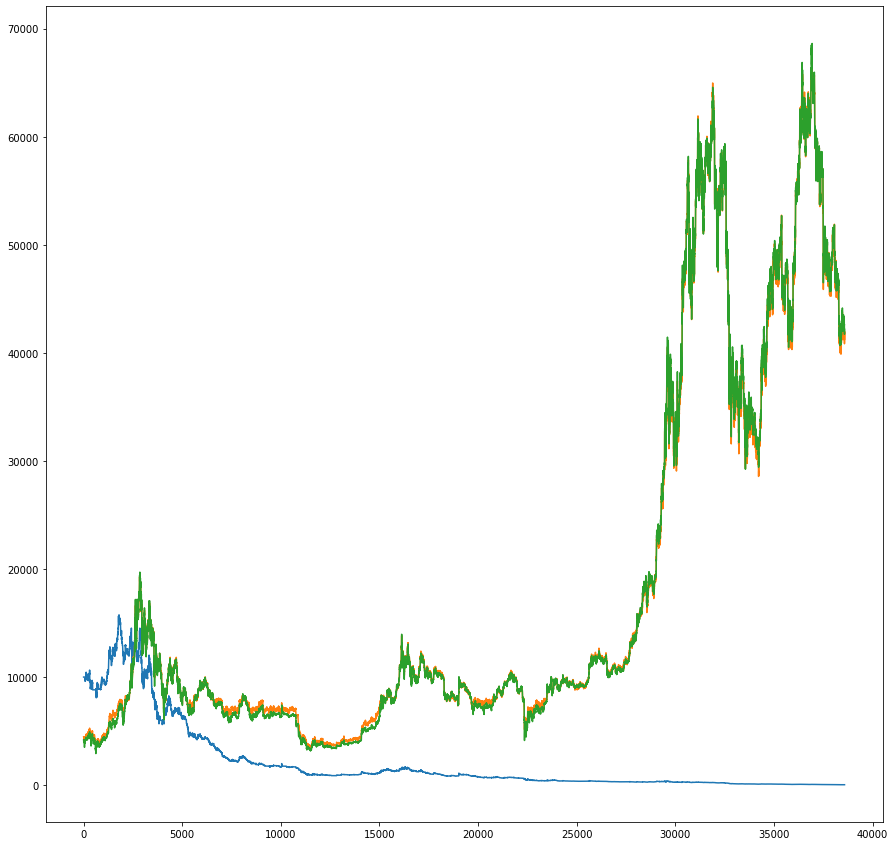

In [21]:
plt.rcParams["figure.figsize"] = (15,15)
# plt.plot(model_trade_x, position_y)
plt.plot(model_trade_x, model_trade_y)
plt.plot(x, unscaled_pred.tolist()[lim:], label="pred")
plt.plot(model_trade_x, data["close"].tail(38582))